In [1]:
import tensorflow as tf
import random
import numpy as np
import matplotlib.pyplot as plt

tf.set_random_seed(777)  # reproducibility

# each pixel valus is float between 0 and 1
# image size = 28x28 = 784, last column means the label that each image indicates
mnist_bg=np.loadtxt('mnist_background_images\\mnist_background_images_train.amat')
print(mnist_bg.shape)


for i in range(8):
    img = mnist_bg[i,:-1].reshape(28,28)
    print(max(mnist_bg[i,:-1]), min(mnist_bg[i,:-1]))
    plt.subplot(1,8,i+1), plt.imshow(img, cmap='gray')

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


(12000, 785)
0.99609375 0.28627451
0.99609375 0.14901961
1.0 0.27058824
0.99609375 0.0
0.99609375 0.15294118
0.99609375 0.0
0.99609375 0.0
0.99609375 0.12156863


In [2]:
# hyper parameters
learning_rate = 0.001
training_epochs = 15
training_size = 12000
batch_size = 100

# dropout (keep_prob) rate  0.7~0.5 on training, but should be 1 for testing
keep_prob = tf.placeholder(tf.float32)

# input place holders
X = tf.placeholder(tf.float32, [None, 784])
X_img = tf.reshape(X, [-1, 28, 28, 1])   # img 28x28x1 (black/white)
Y = tf.placeholder(tf.int32, [None, 10])


# L1 ImgIn shape=(?, 28, 28, 1)
W1 = tf.Variable(tf.random_normal([3, 3, 1, 32], stddev=0.01))
#    Conv     -> (?, 28, 28, 32)
#    Pool     -> (?, 14, 14, 32)
L1 = tf.nn.conv2d(X_img, W1, strides=[1, 1, 1, 1], padding='SAME')
L1 = tf.nn.relu(L1)
L1 = tf.nn.max_pool(L1, ksize=[1, 2, 2, 1],
                    strides=[1, 2, 2, 1], padding='SAME')
L1 = tf.nn.dropout(L1, keep_prob=keep_prob)

# L2 ImgIn shape=(?, 14, 14, 32)
W2 = tf.Variable(tf.random_normal([3, 3, 32, 64], stddev=0.01))
#    Conv      ->(?, 14, 14, 64)
#    Pool      ->(?, 7, 7, 64)
L2 = tf.nn.conv2d(L1, W2, strides=[1, 1, 1, 1], padding='SAME')
L2 = tf.nn.relu(L2)
L2 = tf.nn.max_pool(L2, ksize=[1, 2, 2, 1],
                    strides=[1, 2, 2, 1], padding='SAME')
L2 = tf.nn.dropout(L2, keep_prob=keep_prob)

# L3 ImgIn shape=(?, 7, 7, 64)
W3 = tf.Variable(tf.random_normal([3, 3, 64, 128], stddev=0.01))
#    Conv      ->(?, 7, 7, 128)
#    Pool      ->(?, 4, 4, 128)
#    Reshape   ->(?, 4 * 4 * 128) # Flatten them for FC
L3 = tf.nn.conv2d(L2, W3, strides=[1, 1, 1, 1], padding='SAME')
L3 = tf.nn.relu(L3)
L3 = tf.nn.max_pool(L3, ksize=[1, 2, 2, 1], strides=[
                    1, 2, 2, 1], padding='SAME')
L3 = tf.nn.dropout(L3, keep_prob=keep_prob)
L3_flat = tf.reshape(L3, [-1, 128 * 4 * 4])

# L4 FC 4x4x128 inputs -> 625 outputs
W4 = tf.get_variable("W4", shape=[128 * 4 * 4, 625],
                     initializer=tf.contrib.layers.xavier_initializer())
b4 = tf.Variable(tf.random_normal([625]))
L4 = tf.nn.relu(tf.matmul(L3_flat, W4) + b4)
L4 = tf.nn.dropout(L4, keep_prob=keep_prob)

# L5 Final FC 625 inputs -> 10 outputs
W5 = tf.get_variable("W5", shape=[625, 10],
                     initializer=tf.contrib.layers.xavier_initializer())
b5 = tf.Variable(tf.random_normal([10]))
logits = tf.matmul(L4, W5) + b5

# define cost/loss & optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(
    logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

In [3]:
# initialize
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# train my model
print('Learning started. It takes sometime.')
for epoch in range(training_epochs):
    avg_cost = 0
    total_batch = int(training_size / batch_size)
    
    np.random.shuffle(mnist_bg)

    for i in range(total_batch):
        x_batch = mnist_bg[i*batch_size:(i+1)*batch_size,:-1]
        y_batch = np.zeros((batch_size,10))
        y_batch[np.arange(batch_size), mnist_bg[i*batch_size:(i+1)*batch_size,-1].astype(int)] = 1
        feed_dict={X: x_batch, Y: y_batch, keep_prob:0.7}
        c, _ = sess.run([cost, optimizer], feed_dict=feed_dict)
        avg_cost += c / total_batch

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))
print('Learning Finished!')

Learning started. It takes sometime.
Epoch: 0001 cost = 2.449423607
Epoch: 0002 cost = 2.189833335
Epoch: 0003 cost = 1.346764697
Epoch: 0004 cost = 0.875539472
Epoch: 0005 cost = 0.670407039
Epoch: 0006 cost = 0.556357772
Epoch: 0007 cost = 0.488274385
Epoch: 0008 cost = 0.438748932
Epoch: 0009 cost = 0.405321320
Epoch: 0010 cost = 0.365467146
Epoch: 0011 cost = 0.355118112
Epoch: 0012 cost = 0.320193975
Epoch: 0013 cost = 0.305199749
Epoch: 0014 cost = 0.284030749
Epoch: 0015 cost = 0.283780413
Learning Finished!


In [4]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))
local_accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))



#in sample test
np.random.shuffle(mnist_bg)
ins_accuracy = 0
for i in range(total_batch):
    x_batch = mnist_bg[i*batch_size:(i+1)*batch_size,:-1]
    y_batch = np.zeros((batch_size,10))
    y_batch[np.arange(batch_size),mnist_bg[i*batch_size:(i+1)*batch_size,-1].astype(int)] = 1
    feed_dict={X:x_batch, Y:y_batch, keep_prob:1}
    local = sess.run(local_accuracy, feed_dict=feed_dict)
    ins_accuracy += local / total_batch
    
print('In Sample Accuracy:', ins_accuracy)

In Sample Accuracy: 0.9647500033179923


In [5]:
#out-of sample test

mnist_bg_test=np.loadtxt('mnist_background_images\\mnist_background_images_test.amat')
print(mnist_bg_test.shape)

(50000, 785)


In [6]:
np.random.shuffle(mnist_bg_test)
outs_accuracy = 0
for i in range(500):
    x_batch = mnist_bg_test[i*batch_size:(i+1)*batch_size,:-1]
    y_batch = np.zeros((batch_size,10))
    y_batch[np.arange(batch_size),mnist_bg_test[i*batch_size:(i+1)*batch_size,-1].astype(int)] = 1
    feed_dict={X:x_batch,Y:y_batch, keep_prob:1}
    local = sess.run(local_accuracy, feed_dict=feed_dict)
    outs_accuracy += local / 500
    
print('Out-of Sample Accuracy:', outs_accuracy)

Out-of Sample Accuracy: 0.9241200028657918


Label:  [3] 	Prediction:  [3] 	Correctness:  O
Label:  [2] 	Prediction:  [2] 	Correctness:  O
Label:  [1] 	Prediction:  [1] 	Correctness:  O
Label:  [7] 	Prediction:  [7] 	Correctness:  O
Label:  [9] 	Prediction:  [9] 	Correctness:  O
Label:  [0] 	Prediction:  [0] 	Correctness:  O
Label:  [3] 	Prediction:  [2] 	Correctness:  X
Label:  [3] 	Prediction:  [3] 	Correctness:  O
Label:  [9] 	Prediction:  [9] 	Correctness:  O
Label:  [8] 	Prediction:  [8] 	Correctness:  O


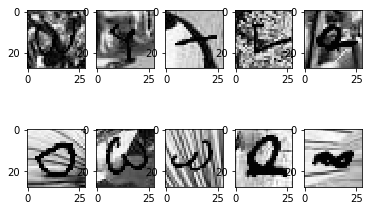

In [25]:
# Get one and predict
def correction(a):
    if a:
        return 'O'
    else:
        return 'X'
    
for i in range(10):
    r = random.randint(0, 50000 - 1)
    test_image = mnist_bg_test[r,:-1]
    test_label = np.zeros((1,10))
    test_label[0,mnist_bg_test[r,-1].astype(int)] = 1
    
    label, prediction = sess.run([tf.argmax(test_label, 1),tf.argmax(logits, 1)], feed_dict={X: test_image.reshape(-1,784), keep_prob:1})
    print("Label: ",label,
          "\tPrediction: ",prediction,
          "\tCorrectness: ", correction(label==prediction))

    plt.subplot(2,5,i+1), plt.imshow(test_image.reshape(28, 28), cmap='Greys')